In [1]:
import cv2
import pandas as pd
from PIL import Image
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from matplotlib import font_manager
plt.rc('font', family='NanumGothic')
%matplotlib inline

from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow.keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

## 1. CNN의 각 Layer 역할 파악

### a. 원본이미지

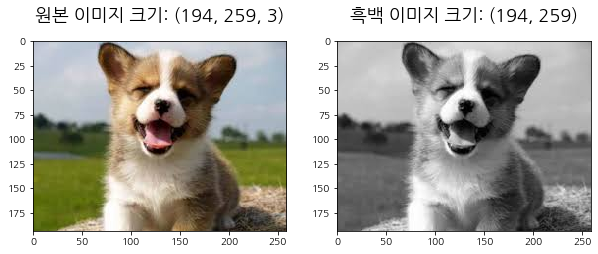

In [2]:
image = cv2.imread("images.png", cv2.IMREAD_GRAYSCALE)
image_origin = cv2.imread("images.png")
image_origin = cv2.cvtColor(image_origin, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,2, figsize=(10,5)) 
ax[0].imshow(image_origin) 
ax[0].set_title("원본 이미지 크기: (%s, %s, %s)"%(image_origin.shape[0], image_origin.shape[1], image_origin.shape[2]), fontsize=18, pad=20);
ax[1].imshow(image, cmap = 'gray') 
ax[1].set_title("흑백 이미지 크기: (%s, %s)"%(image.shape[0], image.shape[1]), fontsize=18, pad=20);

### b. filter의 역할 파악
- filter 역할 : 이미지로부터 특칭을 추출, 필터의 가중치들을 학습하여 사용함
- 검증된 종류 : 소벨 필터

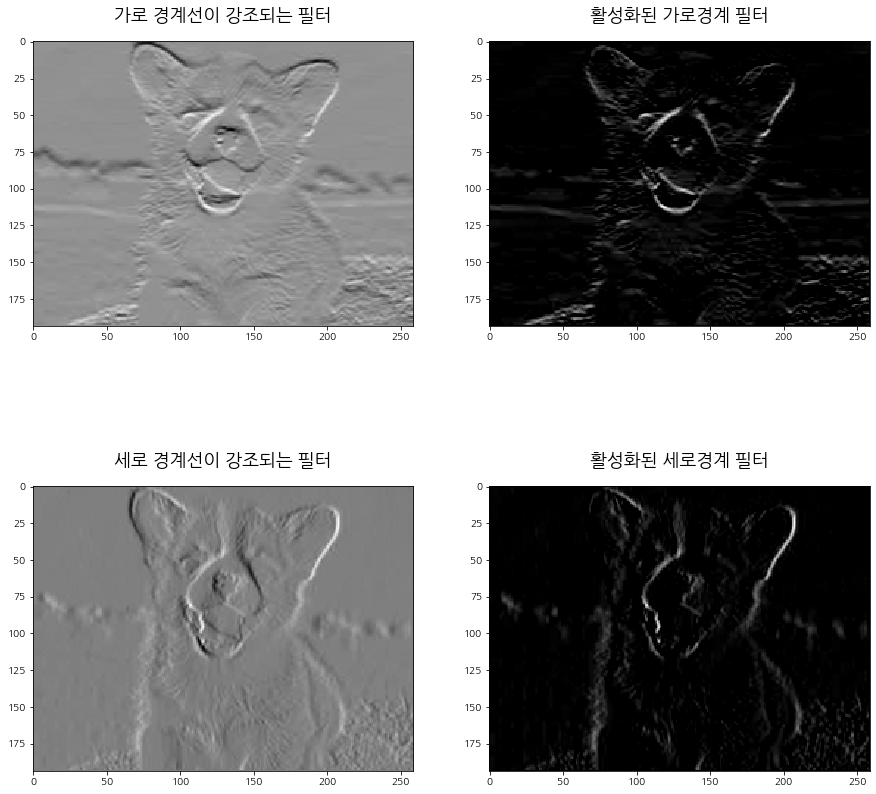

In [5]:
grey_image = rgb2gray(image_origin) # 필터링하기 전 1차원화 작업

# CONV
edge_h_1 = sobel_h(grey_image) # 물체의 가로 경계선이 강조되는 필터
edge_v_1 = sobel_v(grey_image) # 물체의 세로 경계선이 강조되는 필터

# ReLU
edge_h_2 = np.where(edge_h_1 < 0, 0, edge_h_1)
edge_v_2 = np.where(edge_v_1 < 0, 0, edge_v_1)

fig, ax = plt.subplots(2,2, figsize=(15,15)) 
ax[0,0].imshow(edge_h_1, cmap = 'gray');
ax[0,0].set_title("가로 경계선이 강조되는 필터", fontsize=18, pad=20);
ax[0,1].imshow(edge_h_2, cmap = 'gray');
ax[0,1].set_title("활성화된 가로경계 필터", fontsize=18, pad=20);
ax[1,0].imshow(edge_v_1, cmap = 'gray');
ax[1,0].set_title("세로 경계선이 강조되는 필터", fontsize=18, pad=20);
ax[1,1].imshow(edge_v_2, cmap = 'gray');
ax[1,1].set_title("활성화된 세로경계 필터", fontsize=18, pad=20);

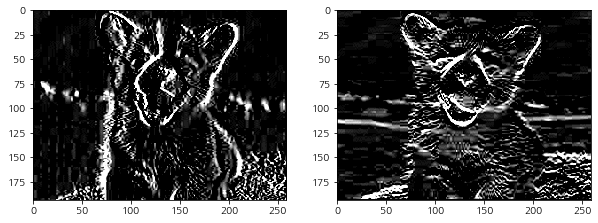

In [6]:
filter1 = np.array([-10,0,10])
filter1 = filter1.reshape(1,-1)
filter2 = filter1.reshape(-1,1)

output1 = cv2.filter2D(image, -1, filter1)
output2 = cv2.filter2D(image, -1, filter2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(output1, cmap= 'gray');
plt.subplot(1,2,2)
plt.imshow(output2, cmap= 'gray');

### b. Conv2d Layer
- 가중치값을 사용하여 필터를 생성한 뒤, 원본이미지와의 합성곱을 통해 필터링 기법 적용
- 특정 픽셀을 주변 픽셀끼리의 연산값으로 대체
- 실제 모델에선 활성화함수를 거치면서, 활성화된 값만 남게 됨

![nn](conv2dlayer.png)

```
conv2d = keras.layers.Conv2D(filters=5, kernel_size=3, strides=(2,2),
                             padding='SAME', kernel_initializer=weight_init)(image)
```
- **filters** : 사용할 필터의 개수
- **kernel_size** : 필터의 크기
- **strides** : 필터 이동 보폭
- **padding** : 필터를 사용하면 출력값 크기가 작아지므로, 이를 그대로 쓸건지 아니면 원본 크기를 유지할건지 결정
- **kernel_initializer** : 필터에 사용할 가중치값 설정

In [7]:
# conv2d layer에 넣기 전에 거쳐야 할 전처리
image = image.reshape(-1, image.shape[0], image.shape[1], 1)
image = image.astype(np.float32) / 255

In [8]:
image = tf.convert_to_tensor(image) #API에 집어넣기 위한 변환
weight_init = keras.initializers.RandomNormal(stddev=0.01) # conv2d의 가중치값 초기화
conv2d = keras.layers.Conv2D(filters=5, kernel_size=3, strides=(2,2),
                             padding='SAME', kernel_initializer=weight_init)(image) # 임의로 5종류의 필터를 생성하여 각각 한번씩 합성곱 계산 진행

print("출력값의 구조: ",conv2d.shape) 

출력값의 구조:  (1, 97, 130, 5)


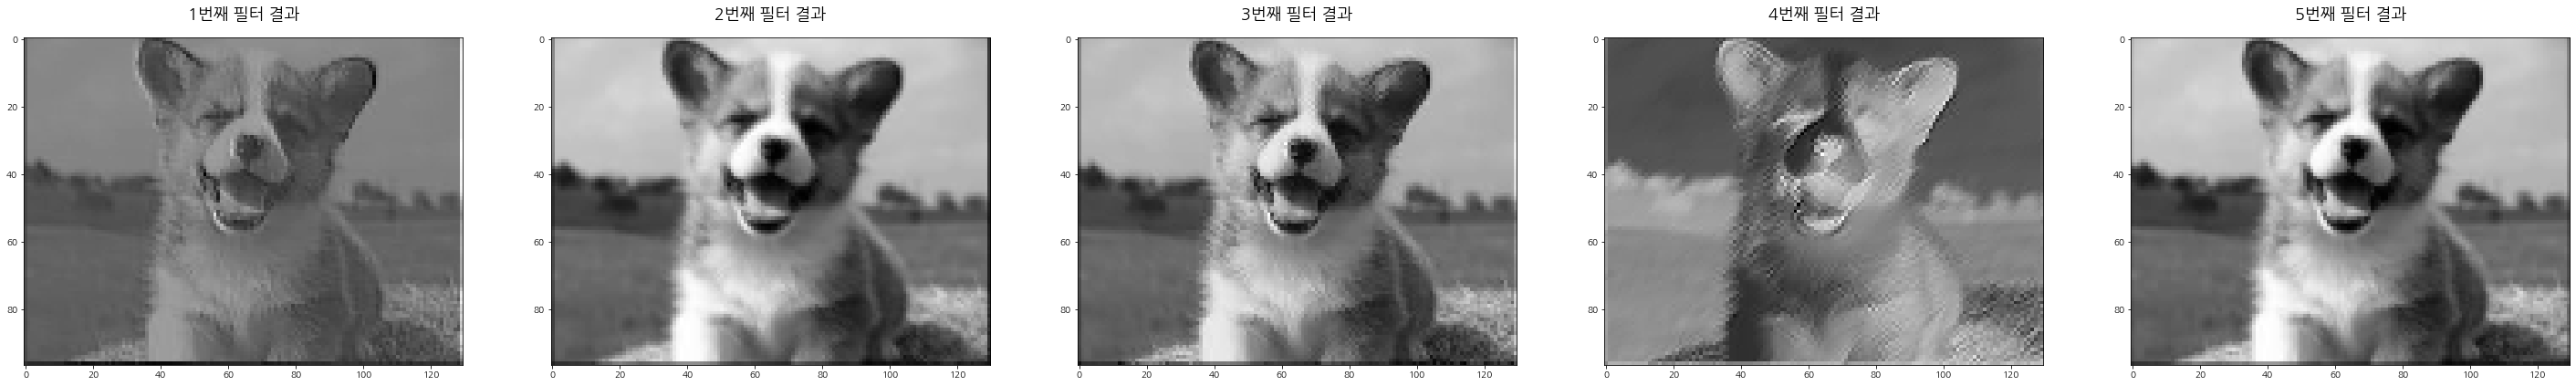

In [9]:
feature_maps = np.swapaxes(conv2d, 0, 3)
fig, ax = plt.subplots(1,5, figsize=(50,10)) 

for i, feature_map in enumerate(feature_maps):
    ax[i].set_title("%s번째 필터 결과"%(i+1), fontsize=18, pad=20) 
    ax[i].imshow(feature_map.reshape(conv2d.shape[1], conv2d.shape[2]), cmap='gray')
plt.show()

##### -> 랜덤으로 생성된 가중치 값에 따라 필터가 생성되므로 필터링 결과도 각기 다름

In [10]:
# kernel size를 3에서 5로 늘림
conv2d_2 = keras.layers.Conv2D(filters=5, kernel_size=5, strides=(2,2),
                             padding='SAME', kernel_initializer=weight_init)(image)

print("출력값의 구조: ",conv2d_2.shape)

출력값의 구조:  (1, 97, 130, 5)


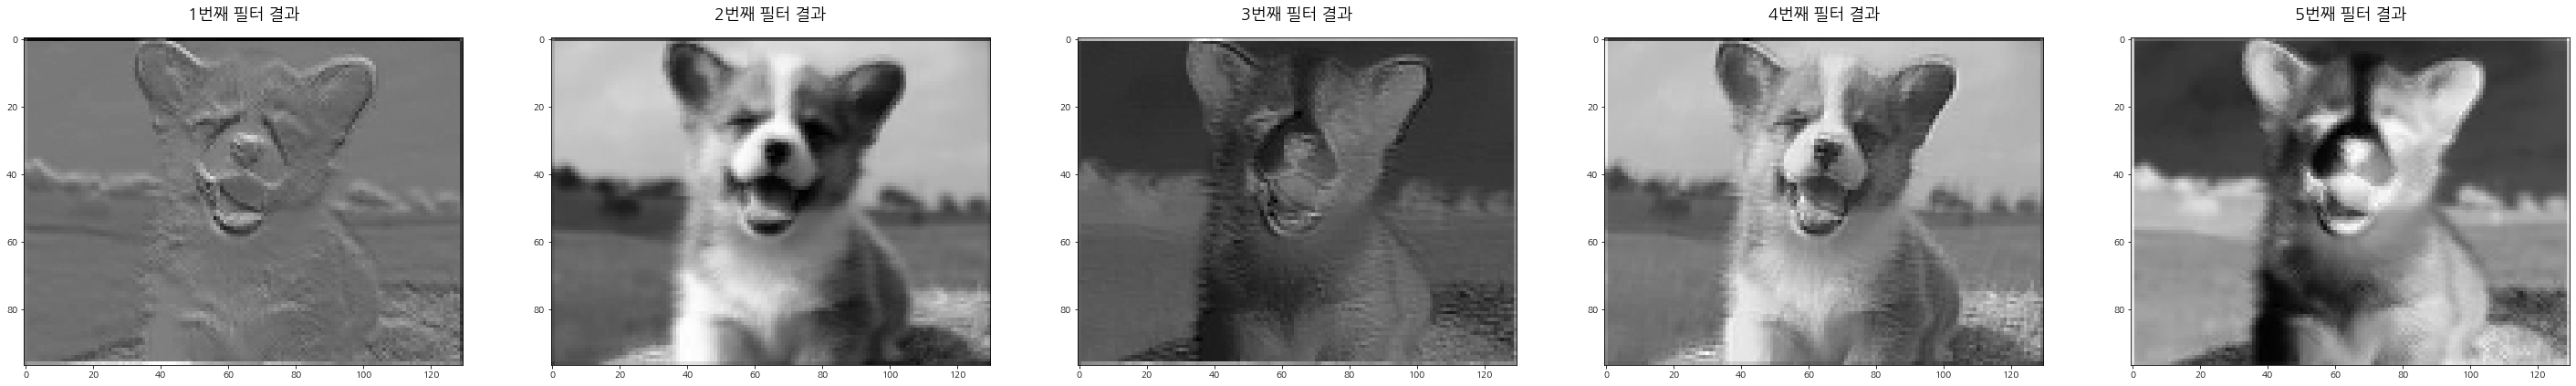

In [11]:
feature_maps = np.swapaxes(conv2d_2, 0, 3)
fig, ax = plt.subplots(1,5, figsize=(50,10)) 

for i, feature_map in enumerate(feature_maps):
    ax[i].set_title("%s번째 필터 결과"%(i+1), fontsize=18, pad=20) 
    ax[i].imshow(feature_map.reshape(conv2d_2.shape[1], conv2d_2.shape[2]), cmap='gray')
plt.show()

### c. MaxPooling Layer
- 이미지의 국소적인 부분들을 하나의 대표적인 스칼라값으로 변환

![nn](poolinglayer.png)

```
pool = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),
                              padding='SAME')(conv2d)
```


- **pool_size** : pooling에 사용할 타일의 크기
- **strides** : 타일의 이동 보폭
- **padding** : 입력 크기를 유지할 것인지 아닌지

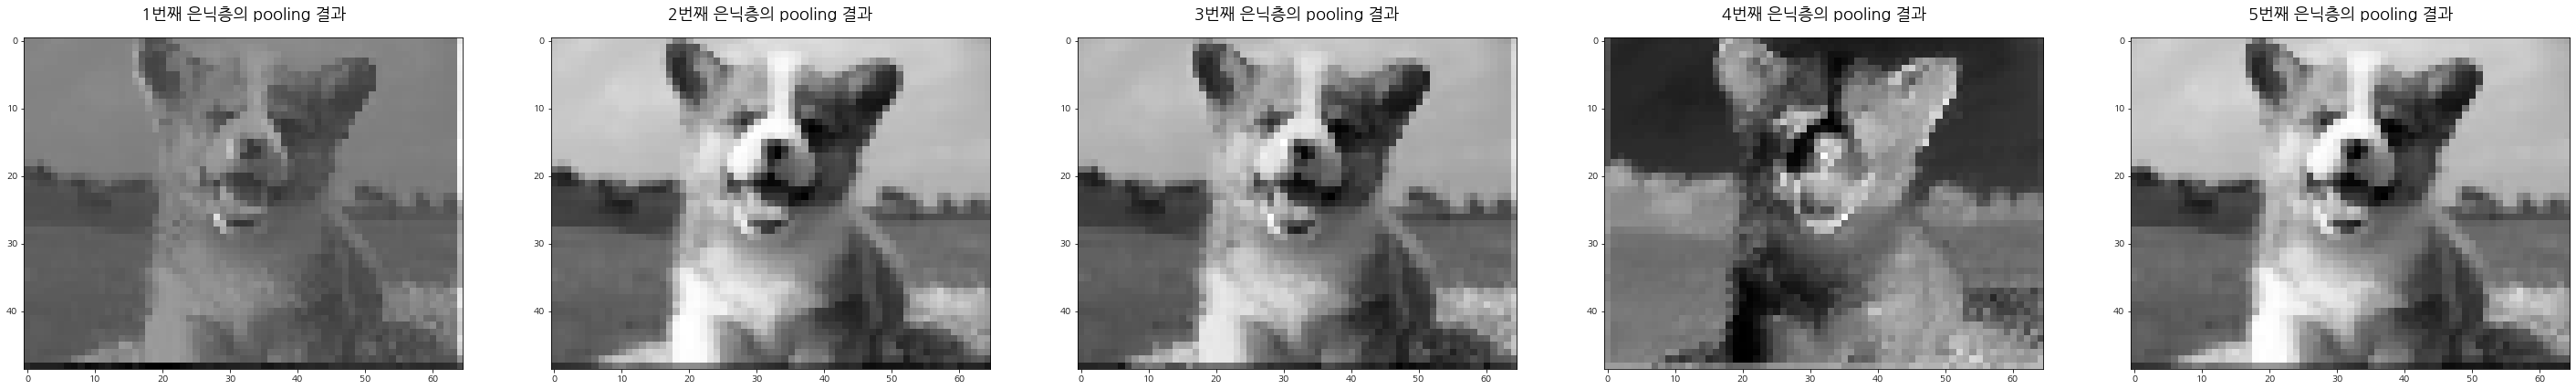

In [12]:
pool = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2),
                              padding='SAME')(conv2d)

fig, ax = plt.subplots(1,5, figsize=(50,10)) 
feature_maps = np.swapaxes(pool, 0, 3)
for i, feature_map in enumerate(feature_maps):
    ax[i].set_title("%s번째 은닉층의 pooling 결과"%(i+1), fontsize=18, pad=20) 
    ax[i].imshow(feature_map.reshape(conv2d.shape[1]//2+1, conv2d.shape[2]//2), cmap='gray')
plt.show()

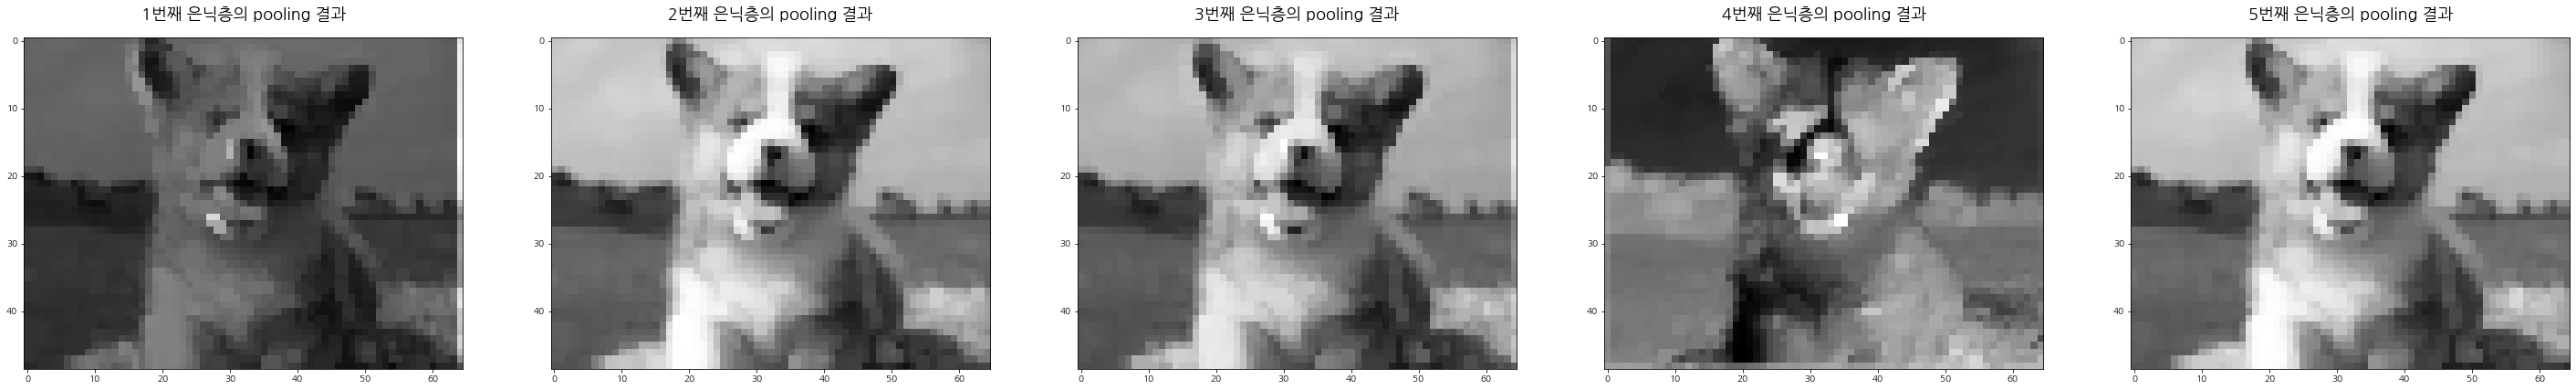

In [13]:
# pool_size를 키움
pool2 = keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2),
                              padding='SAME')(conv2d)

fig, ax = plt.subplots(1,5, figsize=(50,10)) 
feature_maps = np.swapaxes(pool2, 0, 3)
for i, feature_map in enumerate(feature_maps):
    ax[i].set_title("%s번째 은닉층의 pooling 결과"%(i+1), fontsize=18, pad=20) 
    ax[i].imshow(feature_map.reshape(conv2d.shape[1]//2+1, conv2d.shape[2]//2), cmap='gray')
plt.show()

## 2. Data Augmentation 예시
### parameters
1. **rescale** : 이미지의 픽셀값을 0~1 범위로 변경
2. **rotation_range** : 각도범위 변경, 0~180 범위로 설정 가능
3. **width_shift_range** : 수평으로 사진을 이동함
4. **height_shift_range** : 수직으로 사진을 이동함
5. **shear_range** : 사진을 찌그리는 비율
6. **zoom_range** : 사진을 확대하는 비율
7. **horizontal_flip** : 수평으로 뒤집음

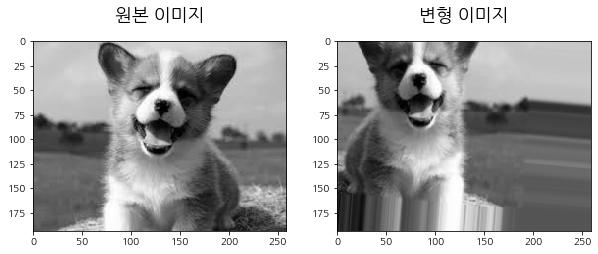

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagenerator = ImageDataGenerator(
    #rescale = 1/255, #이미 진행
    rotation_range = 20, #각도범위(0~180)
    width_shift_range = 0.2, #수평이동범위
    height_shift_range = 0.2, #수직이동범위
    shear_range = 0.2, #찌그리는 형태
    zoom_range = 0.2,#확대비율
    horizontal_flip = True #수평으로 뒤집음
)

image_result = next(iter(datagenerator.flow(image)))

fig, ax = plt.subplots(1,2, figsize=(10,5)) 
ax[0].imshow(np.squeeze(image), 'gray')
ax[0].set_title("원본 이미지", fontsize=18, pad=20) 
ax[1].imshow(np.squeeze(image_result), 'gray')
ax[1].set_title("변형 이미지", fontsize=18, pad=20) 
plt.show()

## 3. CNN 모델 생성

### Fashion MNIST Dataset
![nn](fashion-mnist.png)
- 운동화, 셔츠, 샌들과 같은 작은 이미지들의 모음 
- 열 가지로 분류될 수 있는 28×28 픽셀의 이미지 70,000개로 구성

#### a. 데이터 불러오기

In [15]:
train = pd.read_csv("data/train.csv")
train_pxl = train.drop(['index', 'label'], axis=1)
train_lab = train[['label']]
test = pd.read_csv("data/test.csv").drop(['index'], axis=1)
sample_submission = pd.read_csv("data/sample_submission.csv")

print(train_pxl.shape)
print(train_lab.shape)
print(test.shape)
print(sample_submission.shape)

(60000, 784)
(60000, 1)
(10000, 784)
(10000, 2)


In [16]:
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    display(pil_img)

img = np.array(test.loc[0,:]).reshape(28, 28)
img_show(img)

#### b. 데이터 전처리

- **형태변환** : CNN모델에 넣을 수 있도록 dataframe을 numpy array로 변환하고, train+valid set 분리

In [17]:
train_X = np.array(train_pxl) # df -> np.array로 변환
test_X = np.array(test)
train_y = to_categorical(np.array(train_lab)) # list -> np.array -> category

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=13) # train, valid set 분리

- **reshape** : numpy array를 원본 이미지 크기 형태로 변환하고, CNN에 넣기 위해 값 범위를 0~1로 표현

In [18]:
img_rows, img_cols = 28, 28 # MNIST의 원래 가로세로 크기
input_shape = (img_rows, img_cols, 1) # CNN parameter를 위해 준비

# train dataset을 28x28x1으로 reshape처리
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) 
X_train = X_train.astype('float32')
X_train /= 255

# valid, test에 대해서도 동일하게 전처리
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255
test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
test_X = test_X.astype('float32')
test_X /= 255

- **normalization** : 정규화를 통해 극단적인 값에 대한 영향력 줄임

In [19]:
X_train = (X_train-np.mean(X_train))/np.std(X_train)
X_val = (X_val-np.mean(X_val))/np.std(X_val)
test_X = (test_X-np.mean(test_X))/np.std(test_X)

- **augmentation** : 데이터 변형하여 추가

In [20]:
gen = ImageDataGenerator(rotation_range=8, 
                         width_shift_range=0.08, 
                         shear_range=0.3,
                         height_shift_range=0.08, 
                         zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=256)
val_batches = gen.flow(X_val, y_val, batch_size=256)

#### c. CNN 모델 생성
- **Flatten()**: 특징 추출 레이어에서 분류 레이어로 넘어가기 위해 데이터를 1차원으로 바꾸는 역할
- **Dropout()**: 신경망의 과적합을 방지하기 위해 일부 은닉층을 삭제
- **Dense()**: 활성화 함수를 사용해서 분류를 수행하는 레이어

In [21]:
CNN2 = Sequential()
CNN2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
CNN2.add(MaxPooling2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.25))

CNN2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
CNN2.add(Dropout(0.4))
CNN2.add(Flatten())

CNN2.add(Dense(128, activation='relu'))
CNN2.add(Dropout(0.3))
CNN2.add(Dense(10, activation='softmax'))

CNN2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])

CNN2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0         
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                        

#### d. 모델 훈련

In [22]:
history2 = CNN2.fit_generator(batches, # ImageDataGenerator사용시 fit_generator 사용
                              steps_per_epoch=48000//256, 
                              epochs=10, 
                              validation_data=val_batches, 
                              validation_steps=12000//256, 
                              use_multiprocessing=True)

/home/irteam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
187/187 [==============================] - 14s 71ms/step - loss: 0.7624 - accuracy: 0.7157 - val_loss: 0.5196 - val_accuracy: 0.8043
Epoch 2/10
187/187 [==============================] - 14s 73ms/step - loss: 0.5463 - accuracy: 0.7976 - val_loss: 0.4515 - val_accuracy: 0.8287
Epoch 3/10
187/187 [==============================] - 14s 72ms/step - loss: 0.4896 - accuracy: 0.8171 - val_loss: 0.4128 - val_accuracy: 0.8483
Epoch 4/10
187/187 [==============================] - 14s 72ms/step - loss: 0.4556 - accuracy: 0.8323 - val_loss: 0.3793 - val_accuracy: 0.8587
Epoch 5/10
187/187 [==============================] - 14s 71ms/step - loss: 0.4269 - accuracy: 0.8425 - val_loss: 0.3652 - val_accuracy: 0.8651
Epoch 6/10
187/187 [==============================] - 14s 72ms/step - loss: 0.4017 - accuracy: 0.8503 - val_loss: 0.3445 - val_accuracy: 0.8732
Epoch 7/10
187/187 [==============================] - 14s 72ms/step - loss: 0.3896 - accuracy: 0.8565 - val_loss: 0.3366 - val_accuracy:

In [26]:
score2 = CNN4.evaluate(X_val, y_val, verbose=0)
print('Val loss:', score2[0])
print('Val accuracy:', score2[1])

Val loss: 0.16725532710552216
Val accuracy: 0.9395833611488342


## 4. 모델 예측 결과 확인

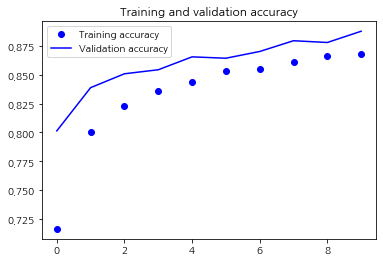

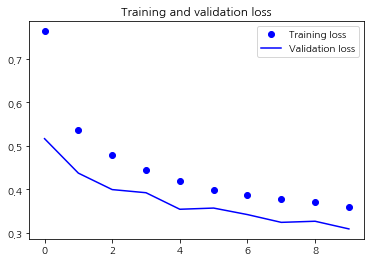

In [30]:
accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(len(accuracy2))

plt.plot(epochs2, accuracy2, 'bo', label='Training accuracy')
plt.plot(epochs2, val_accuracy2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

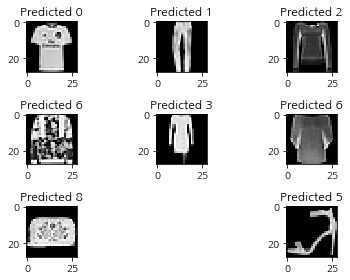

In [31]:
# 9. test dataset에 대해서 결과값 시각화, 입력
pred_test = CNN2.predict(test_X)

for i in range(len(pred_test)):
    temp = np.argmax(pred_test[i])
    for a in range(len(pred_test[0])):
        if a==temp: pred_test[i][a]=1
        else: pred_test[i][a]=0
            
pred_test = np.array(pred_test)
for i in range(0, 9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[i].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}".format(np.argmax(pred_test[i])))
    plt.tight_layout()

### Label
- 0 : T-shirt/top
- 1 : Trouser
- 2 : Pullover (스웨터)
- 3 : Dress
- 4 : Coat
- 5 : Sandal
- 6 : Shirt
- 7 : Sneaker
- 8 : Bag
- 9 : Ankel boot